# Sklearn vs. lsh-forest vs. minHash

Script original from Maheshakya Wijewardena and Olivier Grisel. Extended with minHash and a artificial dataset creation

Index size: 1000, exact: 0.013s, LSHF: 0.035s, speedup: 0.4, accuracy: 0.71 +/-0.00
Index size: 1000, exact: 0.013s, minHash_approx: 0.002s, speedup: 8.0, accuracy: 0.52 +/-0.10
Index size: 1000, exact: 0.013s, minHash_exact: 0.002s, speedup: 5.1, accuracy: 0.08 +/-0.16
Index size: 1820, exact: 0.020s, LSHF: 0.056s, speedup: 0.4, accuracy: 0.54 +/-0.11
Index size: 1820, exact: 0.020s, minHash_approx: 0.001s, speedup: 13.4, accuracy: 0.48 +/-0.16
Index size: 1820, exact: 0.020s, minHash_exact: 0.002s, speedup: 8.1, accuracy: 0.00 +/-0.00
Index size: 3314, exact: 0.037s, LSHF: 0.097s, speedup: 0.4, accuracy: 0.71 +/-0.00
Index size: 3314, exact: 0.037s, minHash_approx: 0.002s, speedup: 21.9, accuracy: 0.36 +/-0.08
Index size: 3314, exact: 0.037s, minHash_exact: 0.003s, speedup: 14.5, accuracy: 0.04 +/-0.08
Index size: 6034, exact: 0.070s, LSHF: 0.105s, speedup: 0.7, accuracy: 0.54 +/-0.06
Index size: 6034, exact: 0.070s, minHash_approx: 0.001s, speedup: 47.2, accuracy: 0.36 +/-0.08
Index

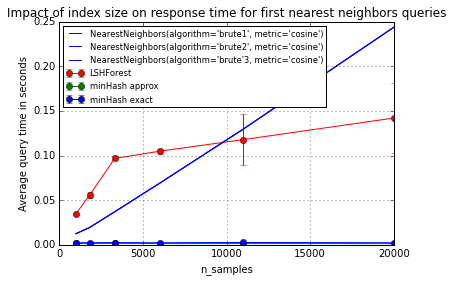

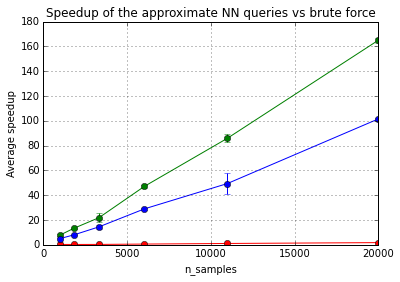

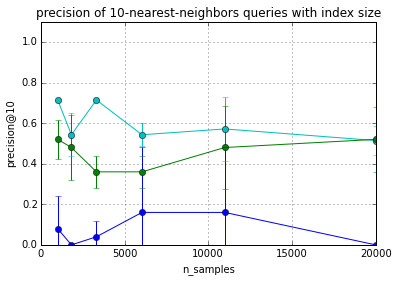

In [1]:
%matplotlib inline
from __future__ import division
# Authors: Maheshakya Wijewardena <maheshakya.10@cse.mrt.ac.lk>
#          Olivier Grisel <olivier.grisel@ensta.org>
#
# License: BSD 3 clause


###############################################################################
import time
import numpy as np
from sklearn.datasets.samples_generator import make_blobs
from sklearn.datasets import make_sparse_uncorrelated
from sklearn.neighbors import LSHForest
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix
import neighborsMinHash as kneighbors
from neighborsMinHash.util import create_dataset
import random

from scipy.sparse import dok_matrix
from scipy.sparse import rand
from scipy.sparse import vstack


# Parameters of the study
n_samples_min = int(1e3)
n_samples_max = 2 * int(1e4)
n_features = 10000
n_centers = 100
n_queries = 100
n_steps = 6
n_iter = 5

# Initialize the range of `n_samples`
n_samples_values = np.logspace(np.log10(n_samples_min),
                               np.log10(n_samples_max),
                               n_steps).astype(np.int)

# Generate some structured data
rng = np.random.RandomState(42)

all_data, _ = create_dataset(seed=6,
                   number_of_centroids=n_centers,
                   number_of_instances=n_samples_max + n_queries,
                   number_of_features=n_features,
                   size_of_dataset=20,
                   density=0.01,
                   fraction_of_density=0.2)
# print all_data
all_data = all_data.toarray()
queries = all_data[:n_queries]
index_data = all_data[:]

# Metrics to collect for the plots
average_times_minHash_exact = []
average_times_minHash_approx = []
std_times_minHash_approx = []
std_times_minHash_exact = []
accuracies_minHash_approx = []
accuracies_minHash_exact = []
std_accuracies_minHash_approx = []
std_accuracies_minHash_exact = []
average_speedups_minHash_approx = []
average_speedups_minHash_exact = []
std_speedups_minHash_approx = []
std_speedups_minHash_exact = []

average_times_exact = []
average_times_approx = []
std_times_approx = []
accuracies = []
std_accuracies = []
average_speedups = []
std_speedups = []

# Calculate the average query time
for n_samples in n_samples_values:
    X = index_data[:n_samples]
    # Initialize LSHForest for queries of a single neighbor
    lshf = LSHForest(n_estimators=20, n_candidates=200,
                     n_neighbors=7).fit(X)
    nbrs = NearestNeighbors(algorithm='auto', metric='minkowski',
                            n_neighbors=5).fit(X)
    nearest_neighbors = kneighbors.MinHashNearestNeighbors(number_of_hash_functions=800,
                                                        max_bin_size = 10,
                                                        block_size = 4, 
                                                        minimal_blocks_in_common = 1,
                                                        excess_factor = 10,
                                                        n_neighbors = 5)
    nearest_neighbors.fit(X)
    time_minHash_approx = []
    time_minHash_exact = []
    accuracy_minHash_exact = []
    accuracy_minHash_approx = []
    
    time_approx = []
    time_exact = []
    accuracy = []

    for i in range(n_iter):
        # pick one query at random to study query time variability in LSHForest
        query = queries[rng.randint(0, n_queries)]

        t0 = time.time()
        exact_neighbors = nbrs.kneighbors(query, return_distance=False)
        time_exact.append(time.time() - t0)

        t0 = time.time()
        approx_neighbors = lshf.kneighbors(query, return_distance=False)
        time_approx.append(time.time() - t0)
        
        t0 = time.time()
        minHash_approx = nearest_neighbors.kneighbors(query, return_distance=False, fast=True)
        time_minHash_approx.append(time.time() - t0)
        
        t0 = time.time()
        minHash_exact = nearest_neighbors.kneighbors(query, return_distance=False, fast=False)
        time_minHash_exact.append(time.time() - t0)
        
        accuracy.append(np.in1d(approx_neighbors, exact_neighbors).mean())
        accuracy_minHash_approx.append(np.in1d(minHash_approx, exact_neighbors).mean())
        accuracy_minHash_exact.append(np.in1d(minHash_exact, exact_neighbors).mean())

    average_time_exact = np.mean(time_exact)
    average_time_approx = np.mean(time_approx)
    average_time_minHash_approx = np.mean(time_minHash_approx)
    average_time_minHash_exact = np.mean(time_minHash_exact)
    speedup = np.array(time_exact) / np.array(time_approx)
    speedup_minHash_approx = np.array(time_exact) / np.array(time_minHash_approx)
    speedup_minHash_exact = np.array(time_exact) / np.array(time_minHash_exact)

    average_speedup = np.mean(speedup)
    average_speedup_minHash_approx = np.mean(speedup_minHash_approx)
    average_speedup_minHash_exact = np.mean(speedup_minHash_exact)

    mean_accuracy = np.mean(accuracy)
    mean_accuracy_minHash_approx = np.mean(accuracy_minHash_approx)
    mean_accuracy_minHash_exact = np.mean(accuracy_minHash_exact)

    std_accuracy = np.std(accuracy)
    std_accuracy_minHash_approx = np.std(accuracy_minHash_approx)
    std_accuracy_minHash_exact = np.std(accuracy_minHash_exact)

    print("Index size: %d, exact: %0.3fs, LSHF: %0.3fs, speedup: %0.1f, "
          "accuracy: %0.2f +/-%0.2f" %
          (n_samples, average_time_exact, average_time_approx, average_speedup,
           mean_accuracy, std_accuracy))
    print("Index size: %d, exact: %0.3fs, minHash_approx: %0.3fs, speedup: %0.1f, "
          "accuracy: %0.2f +/-%0.2f" %
          (n_samples, average_time_exact, average_time_minHash_approx, average_speedup_minHash_approx,
           mean_accuracy_minHash_approx, std_accuracy_minHash_approx))
    print("Index size: %d, exact: %0.3fs, minHash_exact: %0.3fs, speedup: %0.1f, "
          "accuracy: %0.2f +/-%0.2f" %
          (n_samples, average_time_exact, average_time_minHash_exact, average_speedup_minHash_exact,
           mean_accuracy_minHash_exact, std_accuracy_minHash_exact))

    accuracies.append(mean_accuracy)
    std_accuracies.append(std_accuracy)
    average_times_exact.append(average_time_exact)
    average_times_approx.append(average_time_approx)
    std_times_approx.append(np.std(time_approx))
    average_speedups.append(average_speedup)
    std_speedups.append(np.std(speedup))

    accuracies_minHash_approx.append(mean_accuracy_minHash_approx)
    std_accuracies_minHash_approx.append(std_accuracy_minHash_approx)
    average_times_minHash_approx.append(average_time_minHash_approx)
    std_times_minHash_approx.append(np.std(time_minHash_approx))
    average_speedups_minHash_approx.append(average_speedup_minHash_approx)
    std_speedups_minHash_approx.append(np.std(speedup_minHash_approx))
    
    accuracies_minHash_exact.append(mean_accuracy_minHash_exact)
    std_accuracies_minHash_exact.append(std_accuracy_minHash_exact)
    average_times_minHash_exact.append(average_time_minHash_exact)
    std_times_minHash_exact.append(np.std(time_minHash_exact))
    average_speedups_minHash_exact.append(average_speedup_minHash_exact)
    std_speedups_minHash_exact.append(np.std(speedup_minHash_exact))
    
# Plot average query time against n_samples
plt.figure()
plt.errorbar(n_samples_values, average_times_approx, yerr=std_times_approx,
             fmt='o-', c='r', label='LSHForest')
plt.plot(n_samples_values, average_times_exact, c='b',
         label="NearestNeighbors(algorithm='brute1', metric='cosine')")
# minHash approx
plt.errorbar(n_samples_values, average_times_minHash_approx, yerr=std_times_minHash_approx,
             fmt='o-', c='g', label='minHash approx')
plt.plot(n_samples_values, average_times_exact, c='b',
         label="NearestNeighbors(algorithm='brute2', metric='cosine')")
# minHash exact
plt.errorbar(n_samples_values, average_times_minHash_exact, yerr=std_times_minHash_exact,
             fmt='o-', c='b', label='minHash exact')
plt.plot(n_samples_values, average_times_exact, c='b',
         label="NearestNeighbors(algorithm='brute'3, metric='cosine')")
plt.legend(loc='upper left', fontsize='small')
plt.ylim(0, None)
plt.ylabel("Average query time in seconds")
plt.xlabel("n_samples")
plt.grid(which='both')
plt.title("Impact of index size on response time for first "
          "nearest neighbors queries")

# Plot average query speedup versus index size
plt.figure()
plt.errorbar(n_samples_values, average_speedups, yerr=std_speedups,
             fmt='o-', c='r')
# minHash approx
plt.errorbar(n_samples_values, average_speedups_minHash_approx, yerr=std_speedups_minHash_approx,
             fmt='o-', c='g')
# minHash exacr
plt.errorbar(n_samples_values, average_speedups_minHash_exact, yerr=std_speedups_minHash_exact,
             fmt='o-', c='b')
plt.ylim(0, None)
plt.ylabel("Average speedup")
plt.xlabel("n_samples")
plt.grid(which='both')
plt.title("Speedup of the approximate NN queries vs brute force")

# Plot average precision versus index size
plt.figure()
plt.errorbar(n_samples_values, accuracies, std_accuracies, fmt='o-', c='c')
# minHash approx
plt.errorbar(n_samples_values, accuracies_minHash_approx, std_accuracies_minHash_approx, fmt='o-', c='g')
# minHash exact
plt.errorbar(n_samples_values, accuracies_minHash_exact, std_accuracies_minHash_exact, fmt='o-', c='b')
plt.ylim(0, 1.1)
plt.ylabel("precision@10")
plt.xlabel("n_samples")
plt.grid(which='both')
plt.title("precision of 10-nearest-neighbors queries with index size")

plt.show()